In [18]:
import sys
sys.path.append(r'/home/roncax/Git/organ_segmentation_thesis/')
from tqdm import trange
from os import path
import pandas as pd

from OaR_segmentation.db_loaders.HDF5Exploration import HDF5Exploration
from OaR_segmentation.db_loaders.HDF5Dataset import HDF5Dataset

from OaR_segmentation.utilities.paths import Paths
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns


def find_HU_composition(dataset):
    gen = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)
    total_img = None
    with trange(len(gen), unit='batch', leave=False) as tbar:
        for batch in gen:            
            if total_img is None:
                total_img = batch['img']
                shape = np.shape(batch['img'])
            else:
                total_img+= batch['img']
            tbar.update(n=1)

    return total_img/(len(gen))


def plot_HU(tr_HU, test_HU, paths):
    data_tr=tr_HU.detach().cpu().numpy().flatten()
    data_test=test_HU.detach().cpu().numpy().flatten()
    sns.histplot(data=data_tr, color='blue', alpha=0.4, bins=70,binwidth = 1, kde=True)
    hist = sns.histplot(data=data_test, color='red', alpha=0.4, bins=70,binwidth = 1, kde=True)
    hist.set_xlim(left=-1050)
    hist.set_ylim(top = 4000)
    plt.xlabel('HU value')
    plt.ylabel('Count')
    plt.savefig(paths.dir_database+"/HU_analysis.png")
    
def find_organ_percentage(dataset, labels):
    gen = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)
    
    organ_percent = None
    with trange(len(gen), unit='batch', leave=False) as tbar:
        for batch in gen:
            mask = batch['mask'].detach().squeeze().cpu().numpy()
            
            if organ_percent is None:
                organ_percent={}
                for i in labels.keys():
                    organ_percent[i] = np.count_nonzero(mask == int(i))
                organ_percent['0'] = np.count_nonzero(mask == 0)
            else:
                for i in labels.keys():
                    organ_percent[i] += np.count_nonzero(mask == int(i))
                organ_percent['0'] += np.count_nonzero(mask == 0)
                
            tbar.update(n=1)
        
        tot = 0
        for key, value in organ_percent.items():
            tot += value
            
        for key, value in organ_percent.items():
            organ_percent[key] = (value/tot)*100
            
    return organ_percent

def plot_organ_percentage(tr, test, paths):
    fig, axs = plt.subplots(2, 1, figsize=(14,10))

    fig.suptitle('Training and Test Organ Percentages')
    
    
    axs[0].bar([tr['0'],100-tr['0']])
    axs[1].bar([test['0'],100-test['0'] ])
    # axs[0,1].set_title('Test dataset')
    # tr.pop('0')
    # test.pop('0')
    # axs[1,0].pie(tr.values(), labels=tr.keys() , autopct='%1.1f%%')
    # axs[1,1].pie(test.values(), labels=test.keys(), autopct='%1.1f%%')

    # plt.bar(test.keys(), test.values(), color='c')
    # plt.bar(tr.keys(), tr.values(), bottom =list(test.values()),  color='r')
    # plt.xlabel("Organ")
    # plt.ylabel("Frequency")

    plt.show()
    plt.savefig(paths.dir_database+"/Organ_percentage_analysis.png")
    
    
def find_organ_number(dataset, labels):
    gen = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)
    
    organ_num = None
    with trange(len(gen), unit='batch', leave=False) as tbar:
        for batch in gen:
            mask = batch['mask'].detach().squeeze().cpu().numpy()
            
            if organ_num is None:
                organ_num={}
                for i in labels.keys():
                    organ_num[i] = 1 if np.count_nonzero(mask == int(i)) > 0 else 0
            else:
                for i in labels.keys():
                    organ_num[i] += 1 if np.count_nonzero(mask == int(i)) > 0 else 0
            
            
            tbar.update(n=1)
    organ_num['total'] = len(gen)
    return organ_num

def plot_organ_number(tr, test, paths):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,10))
    fig.suptitle('Training and Test HU differences')
    
    ax1.bar(tr.keys() ,tr.values(),  color='c')

    ax1.set_title('Training dataset')
    
    ax2.bar(test.keys(), test.values(), color='c')
    plt.xlabel("Organ")
    plt.ylabel("Frequency")
    ax2.set_title('Test dataset')
    
    
    sns.barplot()

    #plt.show()
    plt.savefig(paths.dir_database+"/OrganxImage_analysis.png")
    plt.close()

def save_imges_from_dicom():
    pass

In [2]:
db_name = "StructSeg2019_Task3_Thoracic_OAR"
platform = "local" #local, gradient, polimi
paths = Paths(db=db_name, platform=platform)
labels = {
"1": "RightLung",
"2": "LeftLung",
"3": "Heart",
"4": "Trachea",
"5": "Esophagus",
"6": "SpinalCord"

    }
    
tr_dataset = HDF5Exploration(hdf5_db_dir=paths.hdf5_db, mode='train',  db_info=json.load(open(paths.json_file_database)))
test_dataset = HDF5Exploration(hdf5_db_dir=paths.hdf5_db, mode='test',  db_info=json.load(open(paths.json_file_database)))


In [3]:

# HU analysis
# training_HU = find_HU_composition(tr_dataset)
# test_HU = find_HU_composition(test_dataset)


# % organ analysis
training_perc = find_organ_percentage(tr_dataset, labels=labels)
test_perc = find_organ_percentage(test_dataset, labels=labels)


# # Organ x image analysis
# training_num = find_organ_number(tr_dataset, labels=labels)
# test_num = find_organ_number(test_dataset, labels=labels)



TypeError: bar() missing 1 required positional argument: 'height'

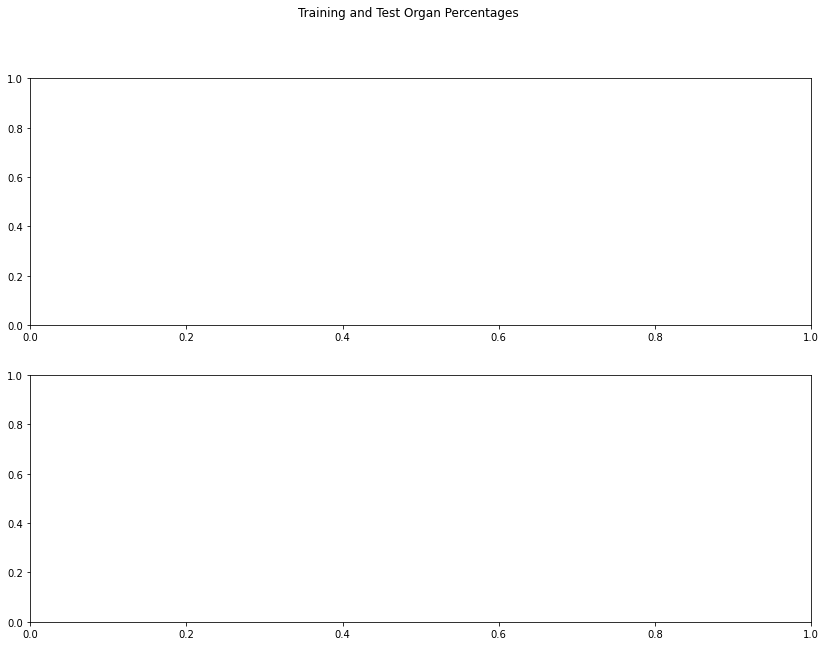

In [19]:
#plot_HU(training_HU, test_HU, paths=paths)
plot_organ_percentage(training_perc, test_perc, paths=paths)
#plot_organ_number(training_num, test_num, paths=paths)